# Setup

In [1]:
!pip install pandas numpy kaggle matplotlib tqdm scikit-image

# Imports

In [16]:
import os
import numpy as np
import pandas as pd
import csv
import zipfile
import re
from skimage.feature import local_binary_pattern
from multiprocessing import Pool, Manager, Value
from matplotlib import pyplot as plt
from tqdm import tqdm
from worker_script import process_batch
from time import sleep
from threading import Thread
from skimage import io, color, util, exposure

# Download/Extract Dataset

In [3]:
# Download raw dataset from Kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


 45%|####5     | 812M/1.76G [00:00<?, ?B/s]
 45%|####5     | 813M/1.76G [00:00<04:02, 4.27MB/s]
 45%|####5     | 814M/1.76G [00:00<03:01, 5.71MB/s]
 45%|####5     | 815M/1.76G [00:00<02:25, 7.13MB/s]
 45%|####5     | 816M/1.76G [00:00<02:23, 7.19MB/s]
 45%|####5     | 817M/1.76G [00:00<02:22, 7.27MB/s]
 45%|####5     | 818M/1.76G [00:00<02:17, 7.48MB/s]
 45%|####5     | 819M/1.76G [00:01<02:09, 7.99MB/s]
 46%|####5     | 820M/1.76G [00:01<02:04, 8.29MB/s]
 46%|####5     | 821M/1.76G [00:01<02:02, 8.41MB/s]
 46%|####5     | 822M/1.76G [00:01<02:18, 7.41MB/s]
 46%|####5     | 823M/1.76G [00:01<02:15, 7.60MB/s]
 46%|####5     | 824M/1.76G [00:01<02:10, 7.88MB/s]
 46%|####5     | 825M/1.76G [00:01<02:00, 8.51MB/s]
 46%|####5     | 826M/1.76G [00:01<02:07, 8.04MB/s]
 46%|####5     | 827M/1.76G [00:02<02:08, 7.95MB/s]
 46%|####5     | 828M/1.76G [00:02<02:00, 8.44MB/s]
 46%|####6     | 829M/1.76G [00:02<02:10, 7.81MB/s]
 46%|####6     | 831M/1.76G [00:02<01:59, 8.53MB/s]
 46%|####6     | 83

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
... resuming from 851443712 bytes (1037921221 bytes left) ...



In [9]:
with zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall(".")

In [11]:
# Path to main folder
image_folder = "lung_colon_image_set"

# Collect all images from subfolders
image_paths = []
for root, dirs, files in os.walk(image_folder):
  dirs.sort()
  for file in sorted(files, key=lambda x: int(re.search(r'(\d+)', x).group())):
    if file.endswith(('.jpeg')):
      image_paths.append(os.path.join(root, file))

# Verify 25,000 jpeg images
print(f"Number of images: {len(image_paths)}")

Number of images: 25000


# Example

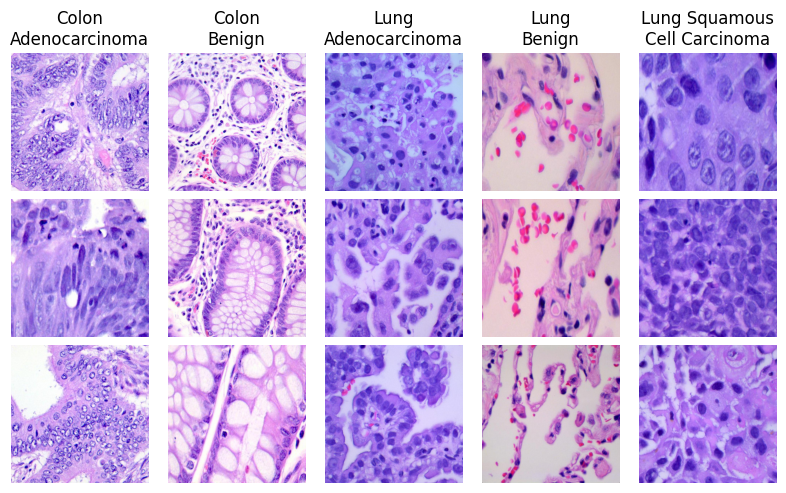

In [12]:
titles = ["Colon\nAdenocarcinoma", "Colon\nBenign", "Lung\nAdenocarcinoma", "Lung\nBenign", "Lung Squamous\nCell Carcinoma"]
path = 1
fig, axes = plt.subplots(3, 5, figsize=(8, 5))

for col in range(5):
    axes[0, col].set_title(titles[col])

    for row in range(3):
        ax = axes[row, col]
        ax.imshow(io.imread(image_paths[path]))
        ax.axis('off')
        path += 1

    path += 5000

# Adjust layout for spacing
plt.tight_layout()

# Save the grid as a JPEG
fig.savefig("5x3_image_grid.jpg", format="jpeg", dpi=300)

# Display the grid
plt.show()

First image path: lung_colon_image_set\colon_image_sets\colon_aca\colonca1.jpeg


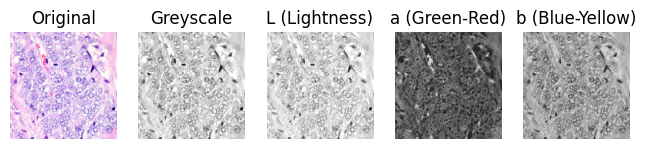

In [29]:
image = io.imread(image_paths[0])
print(f"First image path: {image_paths[0]}")

# Convert to greyscale
greyscale_image = color.rgb2gray(image)
greyscale_image = (greyscale_image * 255).astype(np.uint8)

# Convert to LAB colorspace
lab_image = color.rgb2lab(image)
L_channel = lab_image[:, :, 0]
a_channel = lab_image[:, :, 1]
b_channel = lab_image[:, :, 2]
lab_image = (lab_image * 255).astype(np.uint8)

titles = ["Original", "Greyscale", "L (Lightness)", "a (Green-Red)", "b (Blue-Yellow)"]
images = [image, greyscale_image, L_channel, a_channel, b_channel]

# Plot images
fig, axes = plt.subplots(1, 5, figsize=(8, 5))

for col in range(5):
    ax = axes[col]
    ax.set_title(titles[col])
    
    # Display greyscale images with cmap='gray'
    ax.imshow(images[col], cmap='gray')
    ax.axis('off')

# Save the grid as a JPEG
fig.savefig("Processed_image_grid.jpg", format="jpeg", dpi=300)

plt.show()

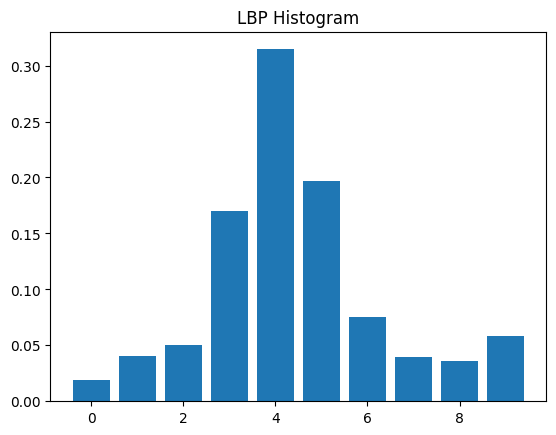

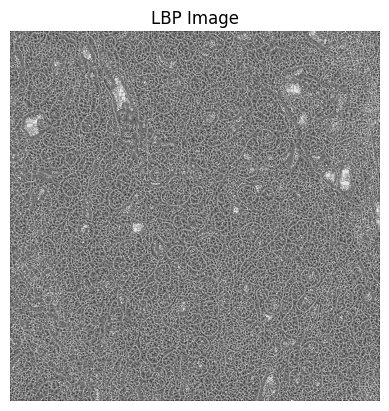

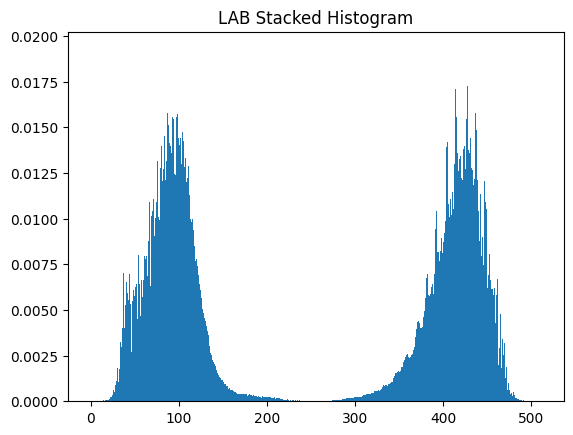

In [31]:
# Apply LBP
radius = 1
n_points = 8 * radius
lbp_test = local_binary_pattern(greyscale_image, n_points, radius, method="uniform")

# Extract LBP histogram
unique_values, counts = np.unique(lbp_test.ravel(), return_counts=True)
num_unique_sequences = len(unique_values)

hist, _ = np.histogram(lbp_test.ravel(), bins=np.append(unique_values, unique_values.max()+1))

# Normalize histogram
hist = hist.astype(np.float32)
hist /= (hist.sum() + 1e-7)

# Plot LBP histogram
plt.figure()
bin_centers = np.arange(num_unique_sequences)
plt.bar(bin_centers, hist, width=0.8)
plt.title("LBP Histogram")

# LBP Image
plt.figure()
plt.imshow(lbp_test, cmap="gray")
plt.title("LBP Image")
plt.axis("off")

# Extract color histogram
hist_A, bin_edges_A = exposure.histogram(a_channel)
hist_B, bin_edges_B = exposure.histogram(b_channel)

# Normalize histograms
hist_A = hist_A / hist_A.sum()
hist_B = hist_B / hist_B.sum()

lab_hist = np.hstack((hist_A.flatten(), hist_B.flatten()))

plt.figure()
bin_centers_lab = np.arange(512)
plt.bar(bin_centers_lab, lab_hist, width=1)
plt.title("LAB Stacked Histogram")
plt.show()

# Image Processing

In [8]:
# Set up batch processing
batch_size = 100

# Create batches
batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

In [ ]:
# Main
if __name__ == "__main__":
    manager = Manager()
    lock = manager.Lock()
    progress_counter = manager.Value('i', 0)
    
    csv_file = 'lung_colon_data.csv'

    lbp_features = [f"LBP_{i+1}" for i in range(10)]
    lab_features = [f"LAB_{i+1}" for i in range(512)]
    label = ['Class']
    header = lbp_features + lab_features + label
    
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    num_workers = os.cpu_count()

    total_images = sum(len(batch) for batch in batches)

    with tqdm(total=total_images, desc="Processing Images") as progress:
        def sync_progress():
            while progress_counter.value < total_images:
                progress.n = progress_counter.value
                progress.refresh()
                sleep(0.5)

            progress.n = progress_counter.value
            progress.refresh()

        progress_thread = Thread(target=sync_progress, daemon=True)
        progress_thread.start()
        
        with Pool(processes=num_workers) as pool:
          pool.starmap(process_batch, [(batch, lock, csv_file, progress_counter) for batch in batches])
    
    progress.close()
    
    print(f"Features saved to {csv_file}")